In [2]:
import numpy as np
from matplotlib import pyplot as plt
import py_gauge_mc

In [3]:
def make_graph(l=8, inv_k=1/2.0,vlen=100):
    graph = py_gauge_mc.GPUGaugeTheory(l,l,l,l,[(n**2)*inv_k for n in range(vlen)])
    #graph = py_gauge_mc.GaugeTheory(l,l,l,l,[(n**2)*inv_k for n in range(vlen)])
    return graph

In [8]:
%%time

ks = np.linspace(0.5, 10.0, 20)

all_windings = []

for L in [4,8,16]:
    print(L, flush=True)
    windings = []

    for k in ks:
        print("\t{}".format(k), flush=True)
        sub_windings = []
        for i in range(10):
            g = make_graph(l=L, inv_k=1/k, vlen=100)
            g.run_local_update(100)
            g.run_global_update()
            winding_var = g.simulate_and_get_winding_variance(1000,10)
            sub_windings.append(winding_var.mean())
        windings.append(sub_windings)
    all_windings.append(windings)
all_windings = np.array(all_windings)

4
	0.5
	1.0
	1.5
	2.0
	2.5
	3.0
	3.5
	4.0
	4.5
	5.0
	5.5
	6.0
	6.5
	7.0
	7.5
	8.0
	8.5
	9.0
	9.5
	10.0
8
	0.5
	1.0
	1.5
	2.0
	2.5
	3.0
	3.5
	4.0
	4.5
	5.0
	5.5
	6.0
	6.5
	7.0
	7.5
	8.0
	8.5
	9.0
	9.5
	10.0
16
	0.5
	1.0
	1.5
	2.0
	2.5
	3.0
	3.5
	4.0
	4.5
	5.0
	5.5
	6.0
	6.5
	7.0
	7.5
	8.0
	8.5
	9.0
	9.5
	10.0
CPU times: user 14min 19s, sys: 15min 14s, total: 29min 33s
Wall time: 30min 29s


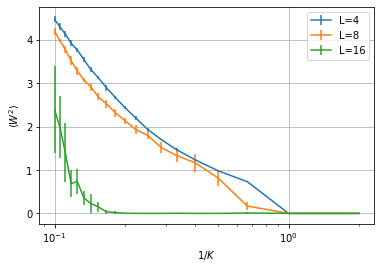

In [13]:
# for i in range(de_errored_windings.shape[-1]):
#     sub_windings = de_errored_windings[:,i]
#     plt.plot(1/ks, sub_windings, c='grey',alpha=0.1)

for l, data in zip([4,8,16], all_windings):
    #plt.plot(1/ks, data.mean(axis=-1), c='r')
    plt.errorbar(1/ks, 
                 data.mean(axis=-1), 
                 yerr=np.sqrt(data.var(axis=-1)),
                 label=f'L={l}')
plt.xscale('log')
plt.grid()
plt.ylabel(r'$\langle W^2 \rangle$')
plt.xlabel(r'$1/K$')
plt.legend()
plt.savefig('confinement.png', dpi=300)
plt.show()